In [1]:
!curl -L https://www.dropbox.com/s/i34l0ul6qs1nwk7/test_points.csv?dl=0 -o test_points.csv
!curl -L https://www.dropbox.com/s/jh0hbzv8aygx0v1/sampleSubmission.csv?dl=0 -o sampleSubmission.csv
!curl -L https://www.dropbox.com/s/m6zd1isw6ni0v5q/data.zip?dl=0 -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 17.5M  100 17.5M    0     0  13.9M      0  0:00:01  0:00:01 --:--:-- 13.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 26.3M  100 26.3M    0     0  11.2M      0  0:00:02  0:00:02 --:--:-- 98.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:

In [2]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/test/images/ad376cc7c6d3839772d1eec8bd162b41.jpg  
  inflating: data/test/images/d24b53c187b578cbf9afb269cc40150d.jpg  
  inflating: data/test/images/c5552f8044a7830ad9ed2f70cc16c1a9.jpg  
  inflating: data/test/images/2979a5aa1c1bca7dc88dda407d69d966.jpg  
  inflating: data/test/images/9c0b05b8dfebc4271fa6eb778a68d8a1.jpg  
  inflating: data/test/images/b01e4a99396b3f24805175ce6812c955.jpg  
  inflating: data/test/images/de00f55dfba5df0167c005fa61c981ef.jpg  
  inflating: data/test/images/953fe3a0590ceeb377e721c8fea650a2.jpg  
  inflating: data/test/images/896f9e28ceb442444f197d165201796d.jpg  
  inflating: data/test/images/efd44352c84d1c109da58de07b870de8.jpg  
  inflating: data/test/images/616c0079347d99433b13ada17b26879a.jpg  
  inflating: data/test/images/162d7de334e9df7fe72288c6697daf49.jpg  
  inflating: data/test/images/e1ced8f7aabf6bf1c6c81d7eb14cea86.jpg  
  inflating: data/test/images/8e4ac574eec354717a5349

In [3]:
import os
tr_names = os.listdir('data/train/images')
test_names = os.listdir('data/test/images')
len(tr_names), len(test_names)

(393930, 99819)

In [0]:
import pandas as pd
landmarks = pd.read_csv('data/train/landmarks.csv', sep='\t', nrows=1000)

In [0]:
train_points = landmarks[landmarks.file_name.isin(tr_names)]
test_points = landmarks[landmarks.file_name.isin(test_names)]

In [6]:
train_points.head()

file_name  Point_0_X  ...  Point_970_X  Point_970_Y
0  07c5e48d938e8d82c0f10973d66183f3.jpg        162  ...          191          166
1  1daf2e7328d121ec280c08f62926e2f9.jpg        136  ...          191          156
2  98d5186671bbcb31a79a16878a57de77.jpg        113  ...          143          120
3  12434863c3a9d9b8b3b0889a4d08d340.jpg        119  ...          182          149
4  28e70684d6e2d6d75a6d3a973e4d4d93.jpg         89  ...          162          202

[5 rows x 1943 columns]

Модель

In [0]:
from torchvision import transforms
from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from argparse import ArgumentParser
from hack_utils import ThousandLandmarksDataset
import os
from torch.utils import data
import pickle
import sys
import numpy as np
import torch.nn as nn
import tqdm
from hack_utils import restore_landmarks_batch, create_submission

import torch
import torchvision
from hack_utils import NUM_PTS, CROP_SIZE
import torchvision.models as models

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
train_transforms = transforms.Compose([
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ("image",)),
    ])

In [10]:
def parse_arguments():
    parser = ArgumentParser(__doc__)
    parser.add_argument("--name", "-n", help="Experiment name (for saving checkpoints and submits).",
                        default="baseline_1")
    parser.add_argument("--data", "-d", help="Path to dir with target images & landmarks.", 
                        default='data/')
    parser.add_argument("--batch-size", "-b", default=512, type=int)  # 512 is OK for resnet18 finetune @ 6Gb of VRAM
    parser.add_argument("--epochs", "-e", default=20, type=int)
    parser.add_argument("--learning-rate", "-lr", default=5e-3, type=float) #1e-3
    parser.add_argument("--gpu", action="store_true", default=True)
    return parser.parse_known_args()[0]
args = parse_arguments()
args

Namespace(batch_size=512, data='data/', epochs=20, gpu=True, learning_rate=0.005, name='baseline_1')

In [11]:
print("Reading data...")
train_dataset = ThousandLandmarksDataset(os.path.join(args.data, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(train_dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True,
                                    shuffle=True, drop_last=True)
val_dataset = ThousandLandmarksDataset(os.path.join(args.data, 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True,
                                  shuffle=False, drop_last=False)

Reading data...


In [12]:
print("Creating model...")
device = torch.device("cuda: 0")

# load a model pre-trained pre-trained on COCO
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)
model.to(device)

Creating model...


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
import torch.optim as optim
from torch.nn import functional as fnn

In [0]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)
        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]
        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())
    return np.mean(val_loss)

def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction
    return predictions

In [0]:
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, amsgrad=True)
loss_fn = fnn.mse_loss

In [16]:
print("Ready for training...")
best_val_loss = np.inf
for epoch in range(args.epochs):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.5}\tval loss: {:5.5}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(f"{args.name}_best.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)

training...:   0%|          | 0/615 [00:00<?, ?it/s]

Ready for training...


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 0:	train loss: 79.727	val loss: 7.0378


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 1:	train loss: 4.3934	val loss: 3.8581


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 2:	train loss: 3.1696	val loss: 2.9364


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 3:	train loss: 2.6879	val loss: 2.5675


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 4:	train loss: 2.4183	val loss: 2.4909


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 5:	train loss: 2.2411	val loss: 2.3619


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 6:	train loss: 2.1383	val loss: 2.2625


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 7:	train loss: 2.0575	val loss: 2.5851


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 8:	train loss: 1.9876	val loss: 2.184


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 9:	train loss: 1.9184	val loss: 2.0916


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch #10:	train loss: 1.8638	val loss: 2.3466


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch #11:	train loss: 1.8195	val loss: 2.0023


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch #12:	train loss: 1.7636	val loss: 2.0445


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch #13:	train loss: 1.7237	val loss: 2.0121


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch #14:	train loss: 1.7096	val loss: 1.9918


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch #15:	train loss: 1.6713	val loss: 1.9914


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch #16:	train loss: 1.6233	val loss: 1.9779


training...:   3%|▎         | 16/615 [00:12<05:25,  1.84it/s]

KeyboardInterrupt: ignored

In [0]:
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate/10, amsgrad=True)

In [18]:
print("Ready for training...")
for epoch in range(2):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.5}\tval loss: {:5.5}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(f"{args.name}_best.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)


training...:   0%|          | 0/615 [00:00<?, ?it/s]

Ready for training...



training...: 100%|██████████| 615/615 [06:30<00:00,  1.58it/s]

validation...: 100%|██████████| 154/154 [01:33<00:00,  1.66it/s]

training...:   0%|          | 0/615 [00:00<?, ?it/s]

Epoch # 0:	train loss: 1.4631	val loss: 1.9297



training...: 100%|██████████| 615/615 [06:34<00:00,  1.56it/s]

validation...: 100%|██████████| 154/154 [01:33<00:00,  1.64it/s]

Epoch # 1:	train loss: 1.3809	val loss: 2.0117


In [28]:
print("Ready for training...")
for epoch in range(4):
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate/(25*(epoch+1)), amsgrad=True)
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.5}\tval loss: {:5.5}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(f"{args.name}_best.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)



training...:   0%|          | 0/615 [00:00<?, ?it/s]

Ready for training...




training...:   0%|          | 1/615 [00:03<34:36,  3.38s/it]

training...:   0%|          | 2/615 [00:03<25:15,  2.47s/it]

training...:   0%|          | 3/615 [00:04<18:49,  1.85s/it]

training...:   1%|          | 4/615 [00:04<14:20,  1.41s/it]

training...:   1%|          | 5/615 [00:05<14:24,  1.42s/it]

training...:   1%|          | 6/615 [00:06<11:16,  1.11s/it]

training...:   1%|          | 7/615 [00:06<09:04,  1.12it/s]

training...:   1%|▏         | 8/615 [00:07<07:29,  1.35it/s]

training...:   1%|▏         | 9/615 [00:08<10:20,  1.02s/it]

training...:   2%|▏         | 10/615 [00:09<08:31,  1.18it/s]

training...:   2%|▏         | 11/615 [00:09<07:09,  1.40it/s]

training...:   2%|▏         | 12/615 [00:10<06:16,  1.60it/s]

training...:   2%|▏         | 13/615 [00:11<09:13,  1.09it/s]

training...:   2%|▏         | 14/615 [00:12<07:38,  1.31it/s]

training...:   2%|▏         | 15/615 [00:12<06:28,  1.54it/s]

training...:   3%|▎         | 16/615 [00:12<05:43,  1.75it/s]


Epoch # 0:	train loss: 1.3325	val loss: 1.7752




training...:   0%|          | 1/615 [00:03<33:41,  3.29s/it]

training...:   0%|          | 2/615 [00:03<24:33,  2.40s/it]

training...:   0%|          | 3/615 [00:04<18:21,  1.80s/it]

training...:   1%|          | 4/615 [00:04<14:01,  1.38s/it]

training...:   1%|          | 5/615 [00:06<14:41,  1.45s/it]

training...:   1%|          | 6/615 [00:06<11:26,  1.13s/it]

training...:   1%|          | 7/615 [00:06<09:10,  1.10it/s]

training...:   1%|▏         | 8/615 [00:07<07:35,  1.33it/s]

training...:   1%|▏         | 9/615 [00:08<10:20,  1.02s/it]

training...:   2%|▏         | 10/615 [00:09<08:24,  1.20it/s]

training...:   2%|▏         | 11/615 [00:09<07:03,  1.43it/s]

training...:   2%|▏         | 12/615 [00:09<06:05,  1.65it/s]

training...:   2%|▏         | 13/615 [00:11<09:18,  1.08it/s]

training...:   2%|▏         | 14/615 [00:12<07:45,  1.29it/s]

training...:   2%|▏         | 15/615 [00:12<06:33,  1.53it/s]

training...:   3%|▎         | 16/615 [00:12<05:44,  1.74it/s]


Epoch # 1:	train loss: 1.2837	val loss: 1.7572




training...:   0%|          | 1/615 [00:03<34:07,  3.33s/it]

training...:   0%|          | 2/615 [00:03<25:02,  2.45s/it]

training...:   0%|          | 3/615 [00:04<18:42,  1.83s/it]

training...:   1%|          | 4/615 [00:04<14:14,  1.40s/it]

training...:   1%|          | 5/615 [00:06<14:45,  1.45s/it]

training...:   1%|          | 6/615 [00:06<11:29,  1.13s/it]

training...:   1%|          | 7/615 [00:06<09:12,  1.10it/s]

training...:   1%|▏         | 8/615 [00:07<07:36,  1.33it/s]

training...:   1%|▏         | 9/615 [00:08<10:18,  1.02s/it]

training...:   2%|▏         | 10/615 [00:09<08:18,  1.21it/s]

training...:   2%|▏         | 11/615 [00:09<06:59,  1.44it/s]

training...:   2%|▏         | 12/615 [00:10<06:04,  1.66it/s]

training...:   2%|▏         | 13/615 [00:11<08:58,  1.12it/s]

training...:   2%|▏         | 14/615 [00:12<07:31,  1.33it/s]

training...:   2%|▏         | 15/615 [00:12<06:25,  1.55it/s]

training...:   3%|▎         | 16/615 [00:12<05:43,  1.74it/s]


Epoch # 2:	train loss: 1.2645	val loss: 1.7472




training...:   0%|          | 1/615 [00:03<33:46,  3.30s/it]

training...:   0%|          | 2/615 [00:03<24:42,  2.42s/it]

training...:   0%|          | 3/615 [00:04<18:29,  1.81s/it]

training...:   1%|          | 4/615 [00:04<14:06,  1.39s/it]

training...:   1%|          | 5/615 [00:05<14:19,  1.41s/it]

training...:   1%|          | 6/615 [00:06<11:20,  1.12s/it]

training...:   1%|          | 7/615 [00:06<09:05,  1.11it/s]

training...:   1%|▏         | 8/615 [00:07<07:31,  1.34it/s]

training...:   1%|▏         | 9/615 [00:08<10:28,  1.04s/it]

training...:   2%|▏         | 10/615 [00:09<08:28,  1.19it/s]

training...:   2%|▏         | 11/615 [00:09<07:06,  1.42it/s]

training...:   2%|▏         | 12/615 [00:10<06:07,  1.64it/s]

training...:   2%|▏         | 13/615 [00:11<09:12,  1.09it/s]

training...:   2%|▏         | 14/615 [00:12<07:47,  1.28it/s]

training...:   2%|▏         | 15/615 [00:12<06:37,  1.51it/s]

training...:   3%|▎         | 16/615 [00:12<05:47,  1.72it/s]


Epoch # 3:	train loss: 1.2477	val loss: 1.7458


In [29]:
# 3. predict
test_dataset = ThousandLandmarksDataset(os.path.join(args.data, 'test'), train_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True,
                                  shuffle=False, drop_last=False)

with open(f"{args.name}_best.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

test_predictions = predict(model, test_dataloader, device)
with open(f"{args.name}_test_predictions.pkl", "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                  "landmarks": test_predictions}, fp)



test prediction...:   0%|          | 0/195 [00:00<?, ?it/s]

test prediction...:   1%|          | 1/195 [00:07<22:52,  7.08s/it]

test prediction...:   1%|          | 2/195 [00:07<16:04,  5.00s/it]

test prediction...:   2%|▏         | 3/195 [00:07<11:19,  3.54s/it]

test prediction...:   2%|▏         | 4/195 [00:07<08:01,  2.52s/it]

test prediction...:   3%|▎         | 5/195 [00:10<08:39,  2.74s/it]

test prediction...:   3%|▎         | 6/195 [00:10<06:09,  1.96s/it]

test prediction...:   4%|▎         | 7/195 [00:11<04:28,  1.43s/it]

test prediction...:   4%|▍         | 8/195 [00:11<03:14,  1.04s/it]

test prediction...:   5%|▍         | 9/195 [00:14<04:53,  1.58s/it]

test prediction...:   5%|▌         | 10/195 [00:14<03:31,  1.15s/it]

test prediction...:   6%|▌         | 11/195 [00:14<02:45,  1.11it/s]

test prediction...:   6%|▌         | 12/195 [00:14<02:02,  1.49it/s]

test prediction...:   7%|▋         | 13/195 [00:17<03:58,  1.31s/it]

test prediction...:   7%|▋         |

In [0]:
create_submission(args.data, test_predictions, f"{args.name}_submit.csv")

**Visualize**

In [0]:
TEST_PREDICTIONS_FILENAME = "baseline_1_test_predictions.pkl"
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [0]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [41]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


In [0]:
import matplotlib.pyplot as plt
import cv2

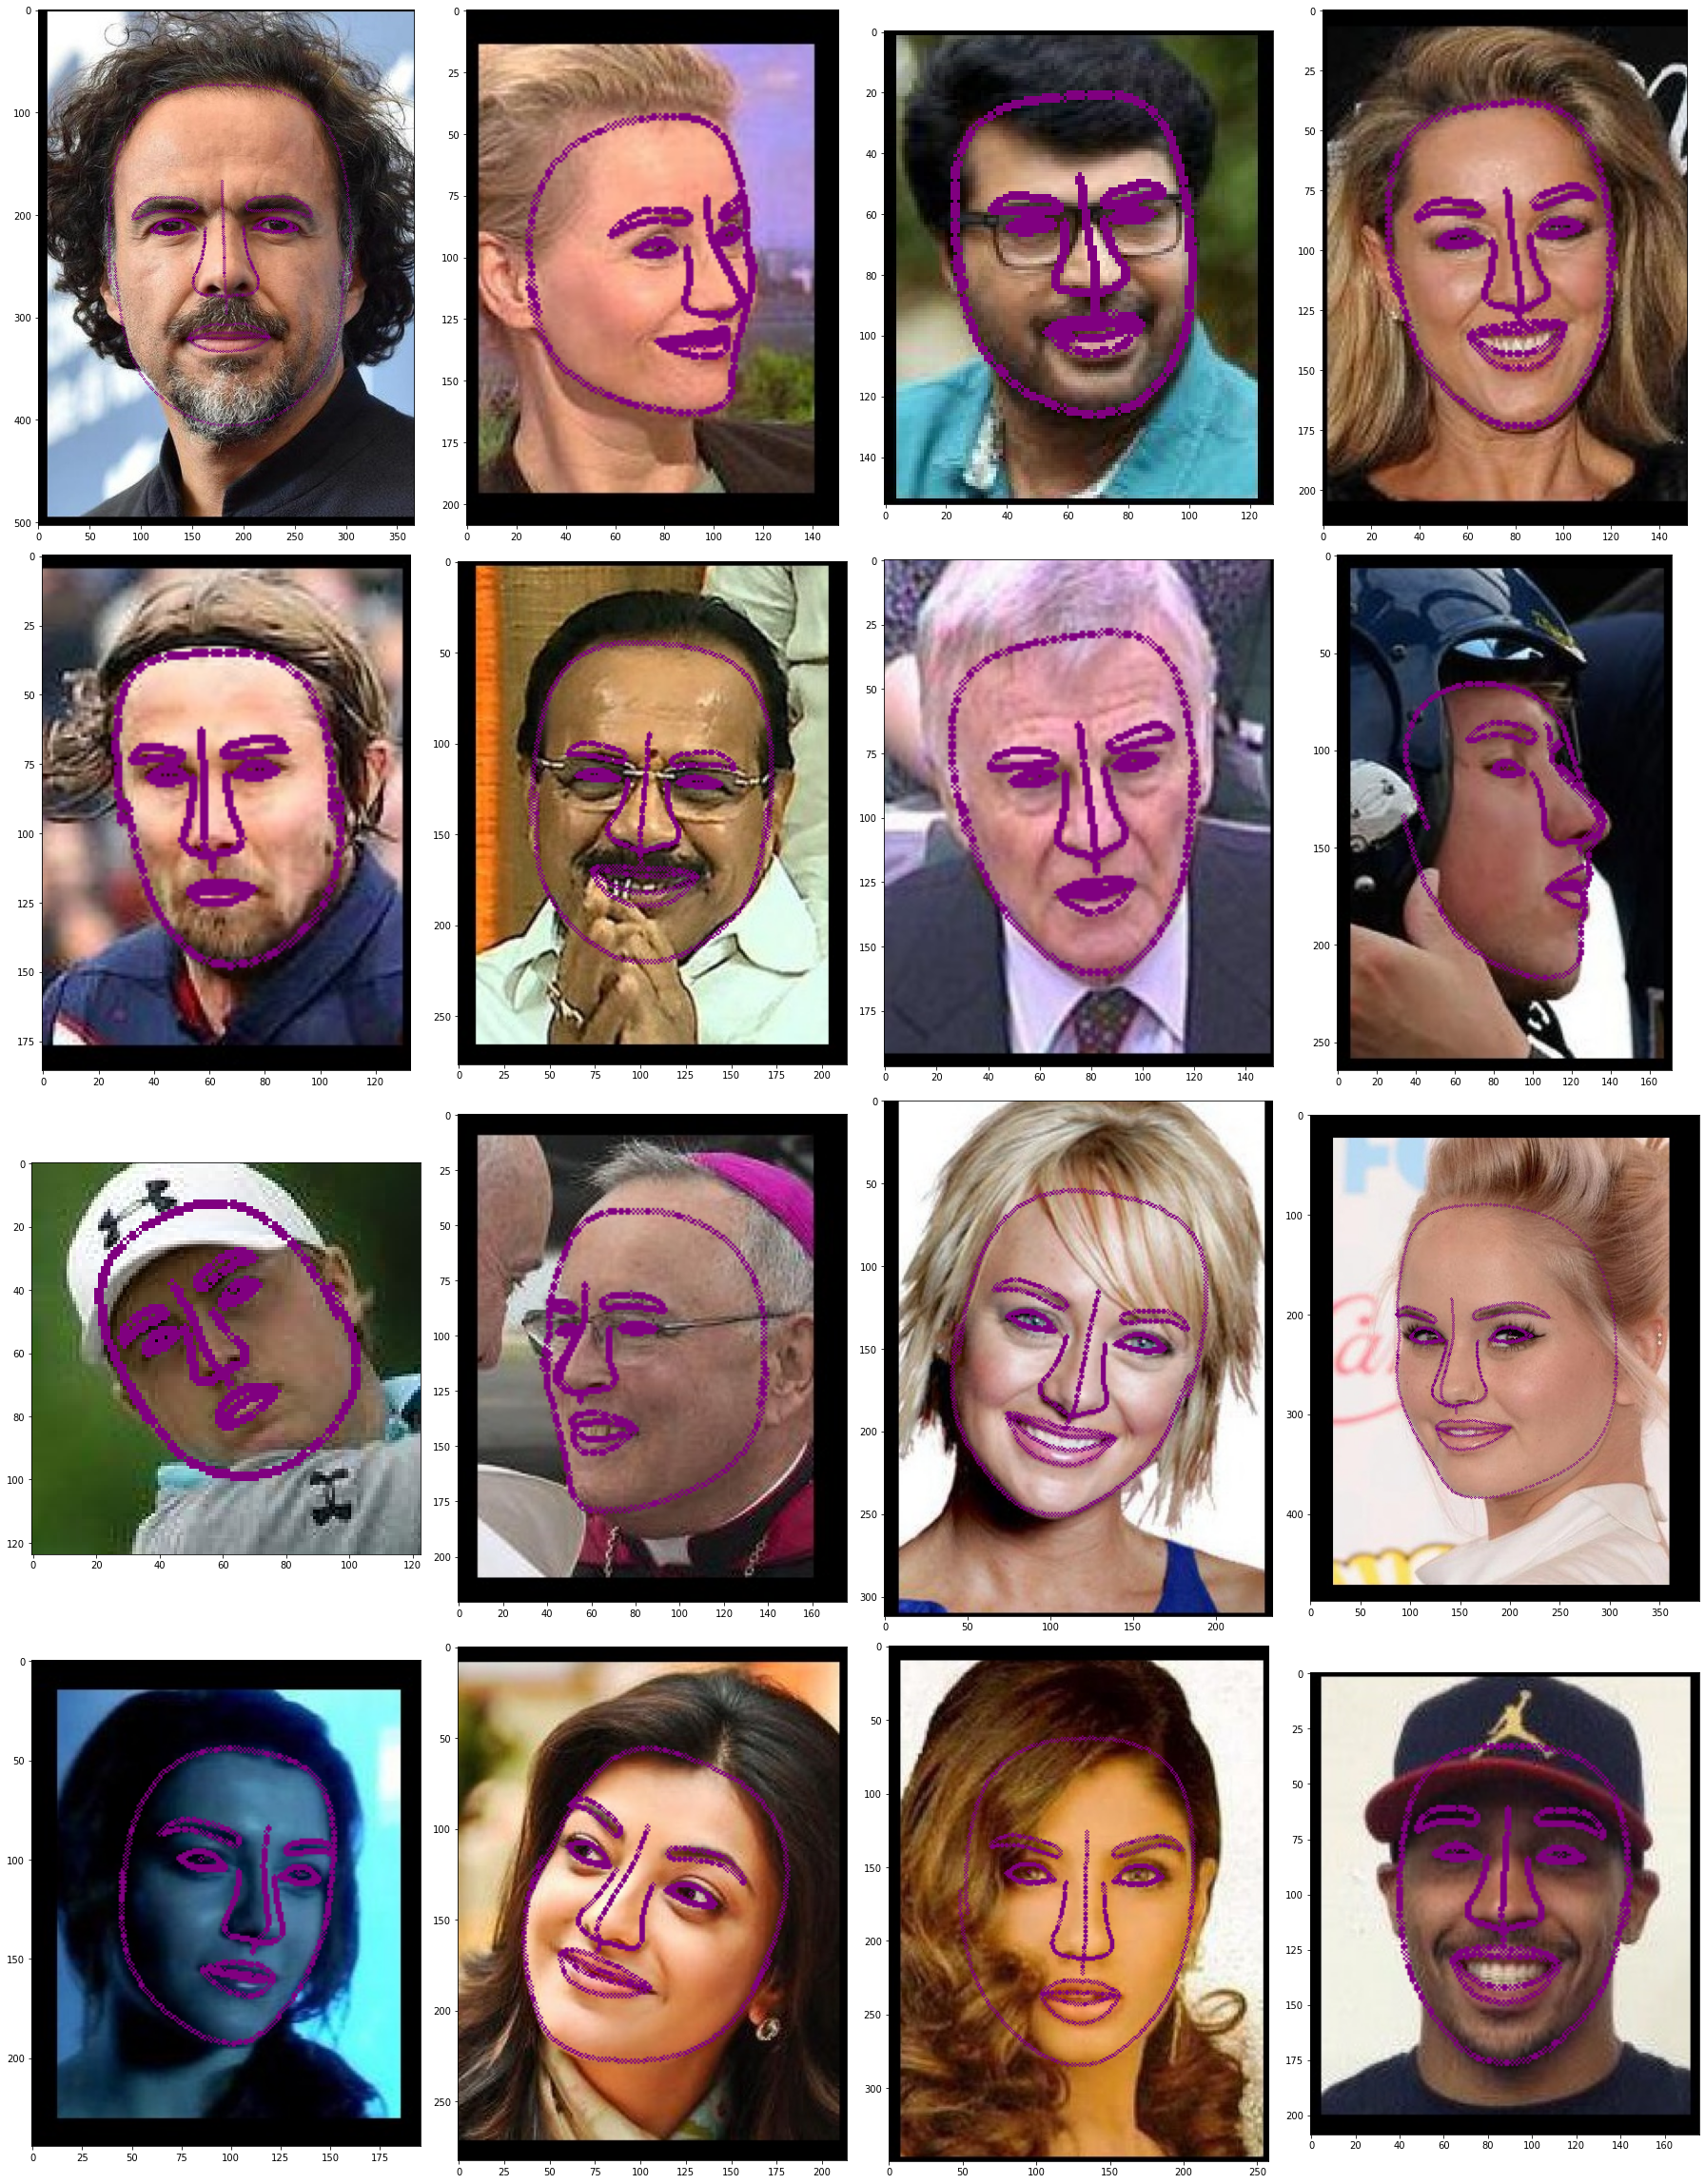

In [46]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()